# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline

# Tensorflow backend initialization

In [2]:
"""
Setup multi GPU usage

Example usage:
model = Sequential()
...
multi_model = multi_gpu_model(model, gpus=num_gpu)
multi_model.fit()

About memory usage:
https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
"""
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib

# IMPORTANT: Tells tf to not occupy a specific amount of memory
from keras.backend.tensorflow_backend import set_session  
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
sess = tf.Session(config=config)  
set_session(sess)  # set this TensorFlow session as the default session for Keras.


# getting the number of GPUs 
def get_available_gpus():
   local_device_protos = device_lib.list_local_devices()
   return [x.name for x in local_device_protos if x.device_type    == 'GPU']
num_gpu = len(get_available_gpus())
print('Amount of GPUs available: %s' % num_gpu)

/opt/jupyterhub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


Amount of GPUs available: 4


# Function definitions

In [3]:
def reduce_memory(df):
    """
    Reduces memory footprint of the input dataframe.
    Changes float64 columns to float32 dtype.
    """
    columns = df.columns
    memory_before = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB

    for column in tqdm(columns):
        if df[column].dtype == 'float64':
            df[column] = df[column].astype('float32')
        
    memory_after = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB
    print('Memory uasge reduced from %.3f GB to %.3f GB' % (memory_before, memory_after))
    
    return df

# Preparing dataframe for preprocessing

In [8]:
%%time
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed//all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()
#df['hour'] = df.index

CPU times: user 1.13 s, sys: 106 ms, total: 1.24 s
Wall time: 1.16 s


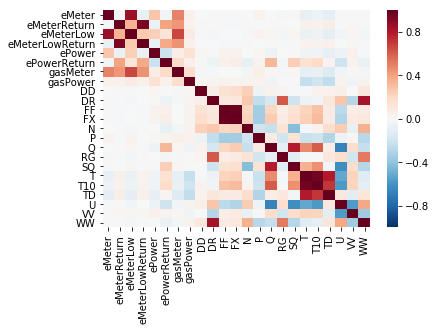

In [11]:
sns.heatmap(df.corr())

In [5]:
%%time
hour = df.resample('1H').mean()
day = day.dropna()
#hour['hour'] = hour.index.hour

CPU times: user 24 s, sys: 9.98 s, total: 34 s
Wall time: 32.4 s


# EDA

In [6]:
sns.heatmap(day.corr())

NameError: name 'hour' is not defined

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(hour['T'], hour['Q'], hour['gasPower'], cmap=plt.cm.viridis, linewidth=0.2, antialiased=True)

ax.set_xlabel('T')
ax.set_ylabel('Q')
ax.set_zlabel('gasPower')

In [ ]:
plt.plot(hour['T'], hour['gasPower'], '.', color='r', label='Original data')
plt.grid()
plt.xlabel('Temperature [°C]')
plt.ylabel('gasPower [m$^3$ per hour]')
plt.legend()

# Preprocessing

# Predict gasPower with most other variables

In [ ]:
seed = 42

data = day

X = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter','gasPower','ePowerReturn', 'ePower', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)
print('X columns: %s' % list(X.columns))
sns.heatmap(X.corr(), annot=True)
X = X.drop(['Q', 'U', 'N', 'DD'], axis=1)
print('X columns final: %s' % list(X.columns))
#sns.heatmap(X.corr(), annot=True)

y = data[['gasPower']]
X = np.array(X).reshape(-1, len(X.columns))
y = np.array(y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)

# fit scalers to training data
scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)
scalery = StandardScaler(with_mean=True, with_std=True).fit(y_train)

# Normalize X arrrays
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)

# Get test data in the correct shape and format
y_train = np.array(y_train).reshape(-1,1) #reshape if y_train is not scaled, transforming should not be needed
y_test = np.array(y_test).reshape(-1,1)

def stats(ndarray):
    shape = ndarray.shape
    var = ndarray.var()
    mean = ndarray.mean()
    std = ndarray.std()
    min_ = ndarray.min()
    max_ = ndarray.max()
    return shape, var, mean, std, min_, max_

print('')
print('X_train -> \t shape: %s \t var: %.1f \t mean: %.1f \t std: %.1f, \t min: %.1f \t max: %.1f'% (stats(X_train)))
print('X_test -> \t shape: %s \t var: %.1f \t mean: %.1f \t std: %.1f, \t min: %.1f \t max: %.1f'% (stats(X_test)))
print('')
print('y_train -> \t shape: %s \t var: %.1E \t mean: %.1E  std: %.1E, \t min: %.1E \t max: %.1E'% (stats(y_train)))
print('y_test -> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E, \t min: %.1E \t max: %.1E'% (stats(y_test)))

# Create the model

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD, Nadam

# Create model
model = Sequential()

activation = 'relu'
#19
model.add(Dense(19, input_shape=(X_train.shape[1],), kernel_initializer='normal'))
model.add(Activation(activation))
model.add(Dropout(0.05, seed=seed)) 

# Dropout: 1 wont ''drop'' any data, 0.5 will drop half of the data
# https://www.quora.com/How-does-the-dropout-method-work-in-deep-learning-And-why-is-it-claimed-to-be-an-effective-trick-to-improve-your-network
N = 45 #45

for i in range(3):
    model.add(Dense(N, kernel_initializer='normal'))
    model.add(Activation(activation))
    model.add(Dropout(0.05, seed=seed))


model.add(Dense(1, kernel_initializer='normal'))
model.add(Activation('linear'))

# Compile & fit

In [ ]:
%%time

# Compile and fit
multi_model = multi_gpu_model(model, gpus=num_gpu)

lr = 0.55
epochs = 1000
#decay_rate = 1*10**(-8)
decay_rate = 0
sgd = SGD(lr=lr, momentum=0.9, decay=decay_rate, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower

# compiling the sequential model
#multi_model.compile(loss='mean_squared_error', optimizer='adam')
multi_model.compile(loss='mean_squared_error', metrics=['mse'], optimizer='sgd')

early_stopping_monitor = EarlyStopping(patience=5000)

from livelossplot import PlotLossesKeras

# training the model and saving metrics in history
multi_model.fit(X_train, y_train, batch_size=int(len(X_train)), epochs=epochs, verbose=2, validation_data=(X_test, y_test), callbacks=[early_stopping_monitor, PlotLossesKeras()])

# Plot results

In [ ]:
# X_test is already transformed
x_pred = X_test
#x_pred = scalerX.transform(x_pred)

y_pred = model.predict(x_pred)


print('x_pred scaled-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

x_pred = scalerX.inverse_transform(x_pred)
print('x_pred inverse-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

# select test variables
FF = x_pred[:,0]
RG = x_pred[:,1]
T = x_pred[:,2]

fig, axarr = plt.subplots(2,2)


axarr[0, 0].plot(day['RG'], day['gasPower']*10000, '.', color='r', alpha=0.3, label='Real')
axarr[0, 0].plot(RG, y_test*10000, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 0].plot(RG, y_pred*10000, '.', color='b', label='Predicted', alpha=0.3)

axarr[0, 0].grid()
axarr[0, 0].set_xlabel('Rain intensity $RG$ [mm/h] \n (10 min mean)')
axarr[0, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-4}$ [m$^3$]')

axarr[0, 1].plot(day['T'], day['gasPower']*10000, '.', color='r', alpha=0.3, label='Real')
axarr[0, 1].plot(T, y_test*10000, 'v', color='g', alpha=0.3, label='X_test, y_test')
axarr[0, 1].plot(T, y_pred*10000, '.', color='b', alpha=0.3, label='Predicted')

axarr[0, 1].grid()
axarr[0, 1].set_xlabel('Temperature at 1,5 m $T$ [$\degree$C] \n (1 min mean)')
axarr[0, 1].set_ylabel(r'gasPower $\cdot$ 10$^{-4}$ [m$^3$]')

axarr[1, 0].plot(day['FF'], day['gasPower']*10000, '.', color='r', alpha=0.3, label='All real data')
axarr[1, 0].plot(FF, y_test*10000, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[1, 0].plot(FF, y_pred*10000, '.', color='b', label='X_test, y_predicted', alpha=0.3)

axarr[1, 0].grid()
axarr[1, 0].set_xlabel('Wind speed $FF$ [m/s] \n (10 min mean)')
axarr[1, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-4}$ [m$^3$]')

fig.delaxes(axarr[1, 1])

mse = multi_model.evaluate(X_test, y_test)[0]
mse_val = str(mse)[:4]
mse_power = str(mse)[-1:]

fig.suptitle('Deep neural network regression results with gasPower as the target \n Validation MSE = %s $\cdot$ 10$^{-%s}$' % (mse_val, mse_power), fontsize = 14)
fig.set_size_inches(10,10)
fig.tight_layout()

fig.subplots_adjust(top=0.9) # Adjust title spacing at the top

axarr[1, 0].legend(loc='lower left', bbox_to_anchor= (1.25, 0.3), borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

In [276]:
fig.savefig('DDN last result.png', dpi=1200)

# Complete plot, commented out
# X_test is already transformed
x_pred = X_test
#x_pred = scalerX.transform(x_pred)

y_pred = model.predict(x_pred)


print('x_pred scaled-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

x_pred = scalerX.inverse_transform(x_pred)
print('x_pred inverse-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

# select test variables
DD = x_pred[:,0]
FF = x_pred[:,1]
N = x_pred[:,2]
Q = x_pred[:,3]
RG = x_pred[:,4]
T = x_pred[:,5]
U = x_pred[:,6]

fig, axarr = plt.subplots(3,3)

axarr[0, 0].plot(day['DD'], day['gasPower']*10000, '.', color='r', alpha=0.3, label='All real data')
axarr[0, 0].plot(x_pred[:,0], y_pred*10000, '.', color='b', label='X_test, y_predict', alpha=0.3)
axarr[0, 0].plot(DD, y_test*10000, '.', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 0].grid()
axarr[0, 0].set_xlabel('Wind direction $DD$ [$\degree$] \n (10 min mean)')
axarr[0, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-4}$ [m$^3$]')

axarr[0, 1].plot(day['N'], day['gasPower']*10000, '.', color='r', alpha=0.3, label='Real')
axarr[0, 1].plot(x_pred[:,2], y_pred*10000, '.', color='b', label='Predicted', alpha=0.3)
axarr[0, 1].plot(N, y_test*10000, '.', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 1].grid()
axarr[0, 1].set_xlabel('Total cloud coverage $N$ [octa]')
axarr[0, 1].set_ylabel(r'gasPower $\cdot$ 10$^{-4}$ [m$^3$]')

axarr[0, 2].plot(day['Q'], day['gasPower']*10000, '.', color='r', alpha=0.3, label='Real')
axarr[0, 2].plot(x_pred[:,3], y_pred*10000, '.', color='b', label='Predicted', alpha=0.3)
axarr[0, 2].plot(Q, y_test*10000, '.', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 2].grid()
axarr[0, 2].set_xlabel('global radiation $Q$ [W/m$^2$] \n (10 min mean)')
axarr[0, 2].set_ylabel(r'gasPower $\cdot$ 10$^{-4}$ [m$^3$]')

axarr[1, 0].plot(day['RG'], day['gasPower']*10000, '.', color='r', alpha=0.3, label='Real')
axarr[1, 0].plot(x_pred[:,4], y_pred*10000, '.', color='b', label='Predicted', alpha=0.3)
axarr[1, 0].plot(RG, y_test*10000, '.', color='g', label='X_test, y_test', alpha=0.3)
axarr[1, 0].grid()
axarr[1, 0].set_xlabel('Rain intensity $RG$ [mm/h] \n (10 min mean)')
axarr[1, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-4}$ [m$^3$]')

axarr[1, 1].plot(day['T'], day['gasPower']*10000, '.', color='r', alpha=0.3, label='Real')
axarr[1, 1].plot(x_pred[:,5], y_pred*10000, '.', color='b', alpha=0.3, label='Predicted')
axarr[1, 1].plot(T, y_test*10000, '.', color='g', alpha=0.3, label='X_test, y_test')
axarr[1, 1].grid()
axarr[1, 1].set_xlabel('Temperature at 1,5 m $T$ [$\degree$C] \n (1 min mean)')
axarr[1, 1].set_ylabel(r'gasPower $\cdot$ 10$^{-4}$ [m$^3$]')

axarr[1, 2].plot(day['U'], day['gasPower']*10000, '.', color='r', alpha=0.3, label='Real')
axarr[1, 2].plot(x_pred[:,6], y_pred*10000, '.', color='b', label='Predicted', alpha=0.3)
axarr[1, 2].plot(U, y_test*10000, '.', color='g', label='X_test, y_test', alpha=0.3)
axarr[1, 2].grid()
axarr[1, 2].set_xlabel('Relative humidity at 1,5m $U$ [%] \n (1 min mean)')
axarr[1, 2].set_ylabel(r'gasPower $\cdot$ 10$^{-4}$ [m$^3$]')

axarr[2, 0].plot(day['FF'], day['gasPower']*10000, '.', color='r', alpha=0.3, label='All real data')
axarr[2, 0].plot(x_pred[:,2], y_pred*10000, '.', color='b', label='X_test, y_predicted', alpha=0.3)
axarr[2, 0].plot(FF, y_test*10000, '.', color='g', label='X_test, y_test', alpha=0.3)
axarr[2, 0].grid()
axarr[2, 0].set_xlabel('Wind speed $FF$ [m/s] \n (10 min mean)')
axarr[2, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-4}$ [m$^3$]')

fig.delaxes(axarr[2, 1])
fig.delaxes(axarr[2, 2])
fig.suptitle('Deep neural network regression results with gasPower as the target \n RMSE = 4.08 $\cdot$ 10$^{-9}$', fontsize = 14)
fig.set_size_inches(10,10)
fig.tight_layout()

fig.subplots_adjust(top=0.9) # Adjust title spacing at the top

axarr[2, 0].legend(loc='lower left', bbox_to_anchor= (2, 0.3), borderaxespad=0, frameon=False, fontsize=14, markerscale=3)